# Поиск по изображениям — PoC

Демонстрационный проект поиска референсных фотографий по текстовому описанию.
Ниже приведён полный пайплайн: загрузка данных, EDA, подготовка и фильтрация, векторизация, обучение моделей, выбор лучшей и демонстрация поиска.


## Импорты и конфигурация
- Импорты библиотек, фиксация seed.
- Настройка путей к данным и изображениям.


In [1]:
!pip install numpy pandas matplotlib -q
!pip install seaborn -q
!pip install scikit-learn -q
!pip install torch torchvision -q
!pip install sentence_transformers -q
!pip install transformers -q
!pip install scipy -q



In [2]:
import warnings
import re
import random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from sklearn.decomposition import TruncatedSVD

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from PIL import Image

warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed_all(RANDOM_STATE)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

BASE_DIR = Path("/Users/apple/Desktop/DS_project/project_5")
DATA_DIR = BASE_DIR / "to_upload"

TRAIN_CSV = DATA_DIR / "train_dataset.csv"
CROWD_TSV = DATA_DIR / "CrowdAnnotations.tsv"
EXPERT_TSV = DATA_DIR / "ExpertAnnotations.tsv"
TEST_QUERIES_CSV = DATA_DIR / "test_queries.csv"
TEST_IMAGES_CSV = DATA_DIR / "test_images.csv"

TRAIN_IMAGES_DIR = DATA_DIR / "train_images"
TEST_IMAGES_DIR = DATA_DIR / "test_images"


## Загрузка данных
- Чтение train/test таблиц и аннотаций.
- Приведение колонок к единому виду.
- Первичная проверка структуры.


In [3]:
def normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [str(c).strip().strip("|") for c in df.columns]
    return df

train_df = pd.read_csv(TRAIN_CSV)

crowd_df = pd.read_csv(
    CROWD_TSV,
    sep="\t",
    header=None,
    names=["image", "query_id", "crowd_share", "crowd_yes", "crowd_no"],
)

expert_df = pd.read_csv(
    EXPERT_TSV,
    sep="\t",
    header=None,
    names=["image", "query_id", "expert_1", "expert_2", "expert_3"],
)

# test_queries имеет разделитель '|' и пустые крайние колонки
raw_test_queries = pd.read_csv(TEST_QUERIES_CSV, sep="|", engine="python")
raw_test_queries = normalize_columns(raw_test_queries)
raw_test_queries = raw_test_queries[[c for c in raw_test_queries.columns if c and "Unnamed" not in c]]

if set(["query_id", "query_text", "image"]).issubset(raw_test_queries.columns):
    test_queries = raw_test_queries[["query_id", "query_text", "image"]].copy()
else:
    test_queries = raw_test_queries.copy()
    test_queries.columns = ["query_id", "query_text", "image"]

test_images = pd.read_csv(TEST_IMAGES_CSV)

# Приводим строковые колонки к единому виду
for df in [train_df, crowd_df, expert_df, test_queries, test_images]:
    for col in df.columns:
        if df[col].dtype == object:
            df[col] = df[col].astype(str).str.strip()

train_df.head()


,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


## Исследовательский анализ данных (EDA)
- Размеры таблиц и число уникальных объектов.
- Распределения по длине текстов и оценкам.
- Первичный взгляд на аннотации.


train_df: (5822, 3)
crowd_df: (47830, 5)
expert_df: (5822, 5)
test_queries: (500, 3)
test_images: (100, 1)

Уникальные изображения в train: 1000
Уникальные query_id в train: 977

Длина текстов (train):
count    5822.000000
mean       11.900550
std         4.162467
min         2.000000
25%         9.000000
50%        11.000000
75%        14.000000
max        34.000000
Name: text_len, dtype: float64


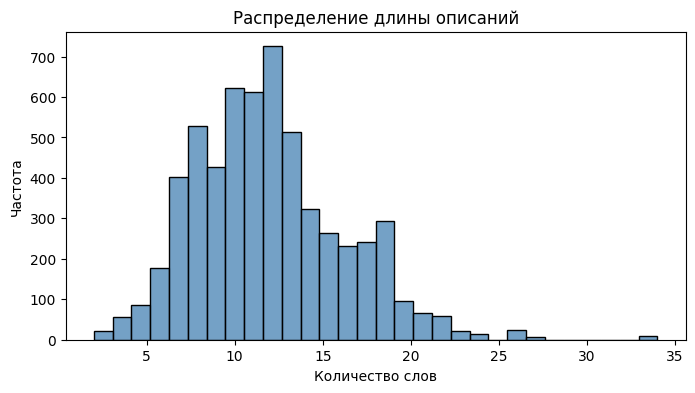

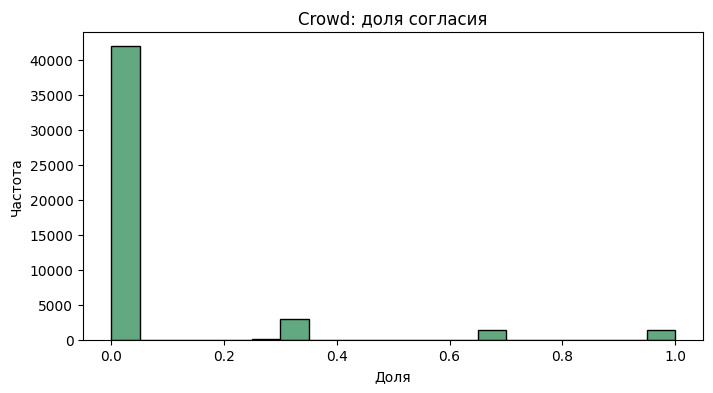

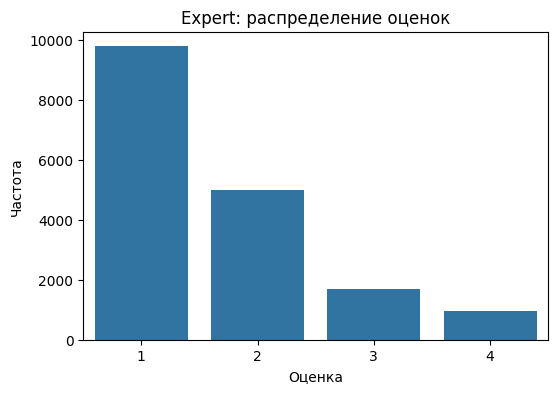

In [4]:
print("train_df:", train_df.shape)
print("crowd_df:", crowd_df.shape)
print("expert_df:", expert_df.shape)
print("test_queries:", test_queries.shape)
print("test_images:", test_images.shape)

print("\nУникальные изображения в train:", train_df["image"].nunique())
print("Уникальные query_id в train:", train_df["query_id"].nunique())

# Длина текстов
train_df["text_len"] = train_df["query_text"].astype(str).str.split().str.len()
print("\nДлина текстов (train):")
print(train_df["text_len"].describe())

plt.figure(figsize=(8, 4))
sns.histplot(train_df["text_len"], bins=30, color="steelblue")
plt.title("Распределение длины описаний")
plt.xlabel("Количество слов")
plt.ylabel("Частота")
plt.show()

# Crowdsourcing: доля согласия
plt.figure(figsize=(8, 4))
sns.histplot(crowd_df["crowd_share"].astype(float), bins=20, color="seagreen")
plt.title("Crowd: доля согласия")
plt.xlabel("Доля")
plt.ylabel("Частота")
plt.show()

# Expert: распределение оценок
expert_scores = pd.concat([
    expert_df["expert_1"],
    expert_df["expert_2"],
    expert_df["expert_3"],
]).astype(int)

plt.figure(figsize=(6, 4))
sns.countplot(x=expert_scores)
plt.title("Expert: распределение оценок")
plt.xlabel("Оценка")
plt.ylabel("Частота")
plt.show()

train_df.drop(columns=["text_len"], inplace=True)


## Агрегация экспертных и крауд-оценок
- Для экспертов — бинаризация: 1–2 → 0, 3–4 → 1; агрегируем по большинству среди 3 экспертов.
- Для крауда — используем долю согласия.
- Собираем несколько вариантов целевой переменной.


In [5]:
def expert_to_binary(value: int) -> int:
    return 1 if int(value) >= 3 else 0

expert_binary = expert_df[["expert_1", "expert_2", "expert_3"]].apply(
    lambda col: col.map(expert_to_binary)
)
expert_df["target_expert"] = (expert_binary.sum(axis=1) >= 2).astype(int)

crowd_df["target_crowd"] = crowd_df["crowd_share"].astype(float).clip(0, 1)

train_full = train_df.merge(
    expert_df[["image", "query_id", "target_expert"]],
    on=["image", "query_id"],
    how="left",
)
train_full = train_full.merge(
    crowd_df[["image", "query_id", "target_crowd"]],
    on=["image", "query_id"],
    how="left",
)
train_full["target_mix"] = 0.6 * train_full["target_expert"] + 0.4 * train_full["target_crowd"]

print("Доля строк с экспертной оценкой:", train_full["target_expert"].notna().mean())
print("Доля строк с крауд-оценкой:", train_full["target_crowd"].notna().mean())
print("Доля строк с mix-оценкой:", train_full["target_mix"].notna().mean())

train_full.head()


Доля строк с экспертной оценкой: 1.0
Доля строк с крауд-оценкой: 0.4000343524562006
Доля строк с mix-оценкой: 0.4000343524562006


,image,query_id,query_text,target_expert,target_crowd,target_mix
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0,0.0,0.0
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0,NaN,NaN
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0,0.0,0.0
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,1.0,1.0
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0,NaN,NaN


## Юридическая фильтрация контента
- Формируем список стоп-слов, связанных с детьми.
- Удаляем такие пары из train.
- Готовим функцию проверки запроса для демо-поиска.


In [6]:
RESTRICTED_WORDS = [
    "child", "children", "kid", "kids", "boy", "boys", "girl", "girls",
    "baby", "babies", "toddler", "toddlers", "teen", "teens",
    "schoolboy", "schoolboys", "schoolgirl", "schoolgirls",
]
restricted_pattern = re.compile(r"\b(" + "|".join(RESTRICTED_WORDS) + r")\b", re.IGNORECASE)

def is_restricted_query(text: str) -> bool:
    if not isinstance(text, str):
        return False
    return bool(restricted_pattern.search(text))

train_full["is_restricted"] = train_full["query_text"].apply(is_restricted_query)
removed_share = train_full["is_restricted"].mean()

train_filtered = train_full.loc[~train_full["is_restricted"]].copy()
train_filtered = train_filtered.reset_index(drop=True)
train_filtered["row_id"] = np.arange(len(train_filtered))

print(f"Удалено по юридическим ограничениям: {removed_share:.2%}")
print("Размер train после фильтрации:", train_filtered.shape)


Удалено по юридическим ограничениям: 26.74%
Размер train после фильтрации: (4265, 8)


## Векторизация текстов
- TF-IDF как базовый быстрый вариант.
- Sentence-BERT как более семантичный вариант (если доступен).
- Сравнение размерностей.


In [7]:
def build_tfidf(texts: pd.Series) -> tuple[TfidfVectorizer, np.ndarray]:
    vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1, 2), min_df=2)
    matrix = vectorizer.fit_transform(texts)
    return vectorizer, matrix

text_embeddings = {}
text_pipelines = {}

# TF-IDF
vectorizer_tfidf, tfidf_matrix = build_tfidf(train_filtered["query_text"])
text_embeddings["tfidf"] = tfidf_matrix
text_pipelines["tfidf"] = {
    "name": "tfidf",
    "vectorizer": vectorizer_tfidf,
}

print("TF-IDF размерность:", tfidf_matrix.shape)

# Sentence-BERT (опционально)
sbert_model = None
sbert_matrix = None
try:
    from sentence_transformers import SentenceTransformer

    sbert_model = SentenceTransformer(
        "sentence-transformers/all-MiniLM-L6-v2",
        device=str(device),
    )
    sbert_matrix = sbert_model.encode(
        train_filtered["query_text"].tolist(),
        batch_size=64,
        show_progress_bar=True,
        normalize_embeddings=True,
    )
    text_embeddings["sbert"] = sbert_matrix
    text_pipelines["sbert"] = {
        "name": "sbert",
        "model": sbert_model,
    }
    print("SBERT размерность:", sbert_matrix.shape)
except Exception as exc:
    print("Sentence-BERT не доступен:", exc)


TF-IDF размерность: (4265, 4380)


Loading weights: 100%|██████████| 103/103 [00:00<00:00, 1530.39it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Batches: 100%|██████████| 67/67 [00:02<00:00, 23.62it/s]

SBERT размерность: (4265, 384)


## Векторизация изображений (ResNet50, PyTorch)
- Используем предобученный ResNet50 без классификатора.
- Получаем эмбеддинг размерности 2048.
- Кэшируем эмбеддинги для ускорения.


In [8]:
weights = models.ResNet50_Weights.IMAGENET1K_V2
preprocess = weights.transforms()

resnet = models.resnet50(weights=weights)
resnet.fc = nn.Identity()
resnet = resnet.to(device).eval()

CACHE_DIR = BASE_DIR / "cache"
CACHE_DIR.mkdir(exist_ok=True)

class ImageDataset(Dataset):
    def __init__(self, image_paths, transform):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        image = Image.open(path).convert("RGB")
        return str(path), self.transform(image)


def build_image_embeddings(image_paths, batch_size=32):
    dataset = ImageDataset(image_paths, preprocess)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    embeddings = {}
    with torch.no_grad():
        for paths, batch in loader:
            batch = batch.to(device)
            features = resnet(batch).cpu().numpy()
            for p, f in zip(paths, features):
                embeddings[Path(p).name] = f
    return embeddings


def load_or_build_embeddings(cache_path: Path, image_paths):
    if cache_path.exists():
        return np.load(cache_path, allow_pickle=True).item()
    embeddings = build_image_embeddings(image_paths)
    np.save(cache_path, embeddings, allow_pickle=True)
    return embeddings

# Готовим список доступных train изображений
train_image_names = sorted(train_filtered["image"].unique())
train_image_paths = [TRAIN_IMAGES_DIR / name for name in train_image_names]

missing_train = [p for p in train_image_paths if not p.exists()]
if missing_train:
    print(f"Не найдено train изображений: {len(missing_train)}. Пример: {missing_train[:3]}")

available_train_images = [p for p in train_image_paths if p.exists()]
train_image_embeddings = load_or_build_embeddings(
    CACHE_DIR / "train_image_embeddings.npy",
    available_train_images,
)

# Готовим список test изображений из test_images.csv
if "image" in test_images.columns:
    test_image_names = test_images["image"].unique().tolist()
else:
    test_image_names = test_images.iloc[:, 0].astype(str).tolist()

test_image_paths = [TEST_IMAGES_DIR / name for name in test_image_names]
missing_test = [p for p in test_image_paths if not p.exists()]
if missing_test:
    print(f"Не найдено test изображений: {len(missing_test)}. Пример: {missing_test[:3]}")

available_test_images = [p for p in test_image_paths if p.exists()]

test_image_embeddings = load_or_build_embeddings(
    CACHE_DIR / "test_image_embeddings.npy",
    available_test_images,
)

print("Train эмбеддинги:", len(train_image_embeddings))
print("Test эмбеддинги:", len(test_image_embeddings))


Train эмбеддинги: 993
Test эмбеддинги: 100


## Формирование обучающей выборки
- Соединяем текстовые и визуальные эмбеддинги.
- Проверяем итоговую размерность.


In [9]:
from scipy import sparse

# Оставляем только строки, для которых есть эмбеддинги изображений
available_train_set = set(train_image_embeddings.keys())
train_ready = train_filtered[train_filtered["image"].isin(available_train_set)].copy()

print("Размер train_ready:", train_ready.shape)


def build_feature_matrix(df: pd.DataFrame, text_matrix, image_embeddings: dict):
    idx = df["row_id"].to_numpy() if "row_id" in df.columns else df.index.to_numpy()
    X_img = np.vstack([image_embeddings[img] for img in df["image"]])

    if sparse.issparse(text_matrix):
        X_text = text_matrix[idx]
        X = sparse.hstack([sparse.csr_matrix(X_img), X_text])
    else:
        X_text = text_matrix[idx]
        X = np.hstack([X_img, X_text])
    return X

# Пример размерности для TF-IDF
X_example = build_feature_matrix(train_ready.head(5), text_embeddings["tfidf"], train_image_embeddings)
print("Пример размерности X:", X_example.shape)


Размер train_ready: (4265, 8)
Пример размерности X: (5, 6428)


## Разбиение train/valid/test без утечки по изображениям
- Используем GroupShuffleSplit, группируем по `image`.
- Гарантируем, что одно и то же изображение не попадает в разные сплиты.


In [10]:
def split_by_image(df: pd.DataFrame, train_size: float = 0.7):
    gss = GroupShuffleSplit(n_splits=1, train_size=train_size, random_state=RANDOM_STATE)
    train_idx, val_idx = next(gss.split(df, groups=df["image"]))
    return df.iloc[train_idx], df.iloc[val_idx]

train_demo, val_demo = split_by_image(train_ready)
print("Train/Val размеры:", train_demo.shape, val_demo.shape)

intersection = set(train_demo["image"]).intersection(set(val_demo["image"]))
print("Пересечение изображений между train и val:", len(intersection))


Train/Val размеры: (3018, 8) (1247, 8)
Пересечение изображений между train и val: 0


## Обучение моделей
- Baseline: линейная регрессия.
- Нейросеть: полносвязный MLP.
- Подбор параметров и сравнение метрик.


In [11]:
def evaluate_target_strategy(df: pd.DataFrame, target_col: str):
    df_target = df[df[target_col].notna()].copy()
    if df_target.empty:
        return np.inf

    y = df_target[target_col].astype(float)
    train_df, val_df = split_by_image(df_target)

    X_train = build_feature_matrix(train_df, text_embeddings["tfidf"], train_image_embeddings)
    X_val = build_feature_matrix(val_df, text_embeddings["tfidf"], train_image_embeddings)

    scaler = MaxAbsScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    model = LinearRegression()
    model.fit(X_train_scaled, y.loc[train_df.index])
    preds = model.predict(X_val_scaled)

    mae = mean_absolute_error(y.loc[val_df.index], preds)
    return mae

# Выбор лучшей цели по базовой метрике
candidate_targets = ["target_expert", "target_crowd", "target_mix"]
mae_by_target = {}
for target in candidate_targets:
    mae_by_target[target] = evaluate_target_strategy(train_ready, target)

mae_by_target

best_target = min(mae_by_target, key=mae_by_target.get)
print("Лучшая стратегия цели:", best_target)

# Финальный датасет под выбранную цель
train_final = train_ready[train_ready[best_target].notna()].copy()

# Сплит для обучения
train_split, val_split = split_by_image(train_final)

y_train = train_split[best_target].astype(float)
y_val = val_split[best_target].astype(float)

# ===== Linear Regression (TF-IDF) =====
X_train_lr = build_feature_matrix(train_split, text_embeddings["tfidf"], train_image_embeddings)
X_val_lr = build_feature_matrix(val_split, text_embeddings["tfidf"], train_image_embeddings)

scaler_lr = MaxAbsScaler()
X_train_lr_scaled = scaler_lr.fit_transform(X_train_lr)
X_val_lr_scaled = scaler_lr.transform(X_val_lr)

model_lr = LinearRegression()
model_lr.fit(X_train_lr_scaled, y_train)

preds_lr = np.clip(model_lr.predict(X_val_lr_scaled), 0, 1)

metrics_lr = {
    "mae": mean_absolute_error(y_val, preds_lr),
    "mse": mean_squared_error(y_val, preds_lr),
    "r2": r2_score(y_val, preds_lr),
}

# ===== MLP (SBERT или TF-IDF+SVD) =====
mlp_text_pipeline = None
if "sbert" in text_embeddings:
    text_matrix_mlp = text_embeddings["sbert"]
    mlp_text_pipeline = text_pipelines["sbert"]
    print("MLP: используем SBERT")
else:
    svd = TruncatedSVD(n_components=300, random_state=RANDOM_STATE)
    text_matrix_mlp = svd.fit_transform(text_embeddings["tfidf"])
    mlp_text_pipeline = {
        "name": "tfidf_svd",
        "vectorizer": text_pipelines["tfidf"]["vectorizer"],
        "svd": svd,
    }
    print("MLP: используем TF-IDF + SVD")

X_train_mlp = build_feature_matrix(train_split, text_matrix_mlp, train_image_embeddings)
X_val_mlp = build_feature_matrix(val_split, text_matrix_mlp, train_image_embeddings)

X_train_mlp = X_train_mlp.toarray() if sparse.issparse(X_train_mlp) else X_train_mlp
X_val_mlp = X_val_mlp.toarray() if sparse.issparse(X_val_mlp) else X_val_mlp

scaler_mlp = StandardScaler()
X_train_mlp = scaler_mlp.fit_transform(X_train_mlp)
X_val_mlp = scaler_mlp.transform(X_val_mlp)

class MLPRegressor(nn.Module):
    def __init__(self, input_dim: int, hidden_dims=(512, 128), dropout=0.2):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = dim
        layers.append(nn.Linear(prev_dim, 1))
        layers.append(nn.Sigmoid())
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


def train_mlp_model(
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_val: np.ndarray,
    y_val: np.ndarray,
    epochs: int = 20,
    batch_size: int = 256,
    lr: float = 1e-3,
    patience: int = 5,
):
    train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
    val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)

    train_ds = torch.utils.data.TensorDataset(train_tensor, y_train_tensor)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    model = MLPRegressor(input_dim=X_train.shape[1]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    best_val = float("inf")
    best_state = None
    no_improve = 0

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            optimizer.zero_grad()
            preds = model(xb)
            loss = loss_fn(preds, yb)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            val_preds = model(val_tensor.to(device)).cpu().numpy().reshape(-1)
            val_mae = mean_absolute_error(y_val, val_preds)

        if val_mae + 1e-6 < best_val:
            best_val = val_mae
            best_state = model.state_dict()
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    return model

model_mlp = train_mlp_model(X_train_mlp, y_train, X_val_mlp, y_val)

model_mlp.eval()
with torch.no_grad():
    preds_mlp = model_mlp(torch.tensor(X_val_mlp, dtype=torch.float32, device=device))
    preds_mlp = preds_mlp.cpu().numpy().reshape(-1)

preds_mlp = np.clip(preds_mlp, 0, 1)

metrics_mlp = {
    "mae": mean_absolute_error(y_val, preds_mlp),
    "mse": mean_squared_error(y_val, preds_mlp),
    "r2": r2_score(y_val, preds_mlp),
}

model_results = [
    {
        "name": "LinearRegression",
        "type": "linear",
        "metrics": metrics_lr,
        "model": model_lr,
        "scaler": scaler_lr,
        "text_pipeline": text_pipelines["tfidf"],
        "train_df": train_split,
        "val_df": val_split,
    },
    {
        "name": "MLP",
        "type": "mlp",
        "metrics": metrics_mlp,
        "model": model_mlp,
        "scaler": scaler_mlp,
        "text_pipeline": mlp_text_pipeline,
        "train_df": train_split,
        "val_df": val_split,
    },
]

model_results


Лучшая стратегия цели: target_expert
MLP: используем SBERT


[{'name': 'LinearRegression',
  'type': 'linear',
  'metrics': {'mae': 0.2807773164411614,
   'mse': 0.1664497304710894,
   'r2': -0.2670270945561444},
  'model': LinearRegression(),
  'scaler': MaxAbsScaler(),
  'text_pipeline': {'name': 'tfidf',
   'vectorizer': TfidfVectorizer(max_features=20000, min_df=2, ngram_range=(1, 2))},
  'train_df':                           image                     query_id  \
  0     1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2   
  1     3187395715_f2940c2b72.jpg  3181701312_70a379ab6e.jpg#2   
  2      463978865_c87c6ca84c.jpg  3181701312_70a379ab6e.jpg#2   
  4      534875358_6ea30d3091.jpg  3181701312_70a379ab6e.jpg#2   
  5     1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2   
  ...                         ...                          ...   
  4258    70995350_75d0698839.jpg  3200120942_59cfbb3437.jpg#2   
  4259   751737218_b89839a311.jpg  2170222061_e8bce4a32d.jpg#2   
  4260   799486353_f665d7b0f0.jpg  2170222061_e8bce4a32d.jpg#

## Метрики и выбор лучшей модели
- Сравнение MAE/MSE/R2.
- Дополнительно — Recall@K для retrieval-сценария.


In [12]:
results_df = pd.DataFrame([
    {
        "model": m["name"],
        "mae": m["metrics"]["mae"],
        "mse": m["metrics"]["mse"],
        "r2": m["metrics"]["r2"],
    }
    for m in model_results
])

display(results_df.sort_values("mae"))

best_model_name = results_df.sort_values("mae").iloc[0]["model"]
best_bundle = next(m for m in model_results if m["name"] == best_model_name)
print("Лучшая модель по MAE:", best_model_name)


def encode_text(text: str, pipeline: dict):
    if pipeline["name"] == "tfidf":
        return pipeline["vectorizer"].transform([text])
    if pipeline["name"] == "sbert":
        return pipeline["model"].encode([text], normalize_embeddings=True)
    if pipeline["name"] == "tfidf_svd":
        vec = pipeline["vectorizer"].transform([text])
        return pipeline["svd"].transform(vec)
    raise ValueError("Unknown text pipeline")


def build_query_matrix(text_vec, image_names, image_embeddings, pipeline: dict):
    img_matrix = np.vstack([image_embeddings[name] for name in image_names])
    if sparse.issparse(text_vec):
        text_block = sparse.vstack([text_vec] * len(image_names))
        return sparse.hstack([sparse.csr_matrix(img_matrix), text_block])
    text_block = np.repeat(text_vec, len(image_names), axis=0)
    return np.hstack([img_matrix, text_block])


def predict_scores(bundle: dict, X):
    if bundle["type"] == "linear":
        X_scaled = bundle["scaler"].transform(X)
        preds = bundle["model"].predict(X_scaled)
    else:
        X_dense = X.toarray() if sparse.issparse(X) else X
        X_scaled = bundle["scaler"].transform(X_dense)
        with torch.no_grad():
            preds = bundle["model"](
                torch.tensor(X_scaled, dtype=torch.float32, device=device)
            ).cpu().numpy().reshape(-1)
    return np.clip(preds, 0, 1)


def recall_at_k(bundle: dict, df_val: pd.DataFrame, k: int = 5) -> float:
    image_names = sorted(df_val["image"].unique())
    queries = df_val[["query_id", "query_text"]].drop_duplicates().copy()
    queries["true_image"] = queries["query_id"].str.split("#").str[0]
    queries = queries[queries["true_image"].isin(image_names)]

    if queries.empty:
        return np.nan

    hits = 0
    for _, row in queries.iterrows():
        text_vec = encode_text(row["query_text"], bundle["text_pipeline"])
        X_query = build_query_matrix(text_vec, image_names, train_image_embeddings, bundle["text_pipeline"])
        scores = predict_scores(bundle, X_query)
        top_k = [image_names[i] for i in np.argsort(scores)[::-1][:k]]
        if row["true_image"] in top_k:
            hits += 1
    return hits / len(queries)

recall5 = recall_at_k(best_bundle, best_bundle["val_df"], k=5)
print("Recall@5 (val):", recall5)


,model,mae,mse,r2
1,MLP,0.148474,0.123671,0.058609
0,LinearRegression,0.280777,0.166450,-0.267027


Лучшая модель по MAE: MLP
Recall@5 (val): 0.13095238095238096


## Тестирование и демо-поиск
- Функция поиска по тексту.
- Дисклеймер при юридически ограниченных запросах.
- Визуальная проверка на 10 случайных запросах.


Запрос: A group of girls who are gothically dressed standing together
This image is unavailable in your country in compliance with local laws
--------------------------------------------------------------------------------
Запрос: A woman and girl riding downhill on a sled with a dog running alongside them
This image is unavailable in your country in compliance with local laws
--------------------------------------------------------------------------------
Запрос: The dog is running .
Лучшее изображение: 634891010_9fa189effb.jpg | score=1.000


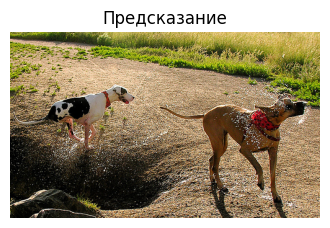

Релевантное (из test_queries): 3488087117_2719647989.jpg


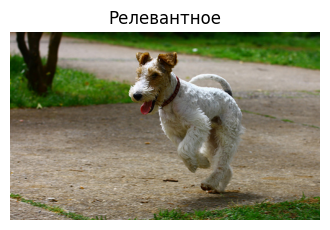

--------------------------------------------------------------------------------
Запрос: A group of people are ice skating in a big city .
Лучшее изображение: 3287969199_08e775d896.jpg | score=0.960


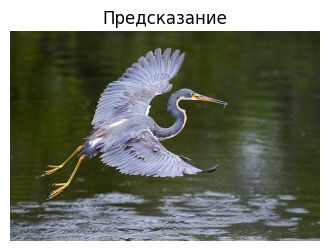

Релевантное (из test_queries): 269650644_059a84ece5.jpg


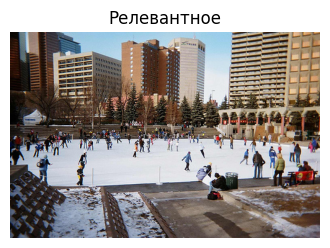

--------------------------------------------------------------------------------
Запрос: Little kid in blue coat and hat riding a tricycle .
This image is unavailable in your country in compliance with local laws
--------------------------------------------------------------------------------
Запрос: Two black dogs fighting over an orange toy .
Лучшее изображение: 1745110280_0cbff5e273.jpg | score=0.935


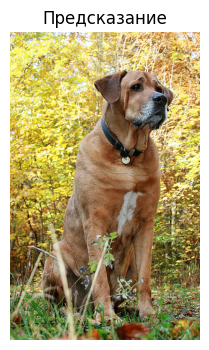

Релевантное (из test_queries): 3553476195_fb3747d7c1.jpg


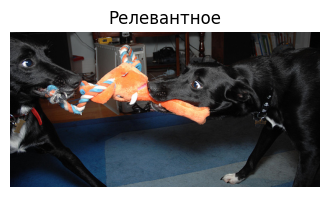

--------------------------------------------------------------------------------
Запрос: A dog jumping for a tennis ball near an ocean
Лучшее изображение: 3287969199_08e775d896.jpg | score=0.990


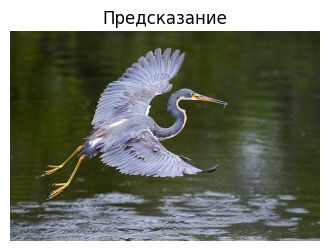

Релевантное (из test_queries): 3514297698_0512623955.jpg


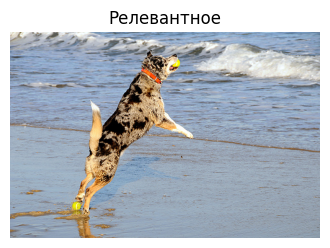

--------------------------------------------------------------------------------
Запрос: Boy flying a distant kite .
This image is unavailable in your country in compliance with local laws
--------------------------------------------------------------------------------
Запрос: kids play ultimate Frisbee .
This image is unavailable in your country in compliance with local laws
--------------------------------------------------------------------------------
Запрос: A girl in a purple shirt feeding ducks
This image is unavailable in your country in compliance with local laws
--------------------------------------------------------------------------------


In [13]:
DISCLAIMER = "This image is unavailable in your country in compliance with local laws"


def show_image(image_path: Path, title: str | None = None):
    if not image_path.exists():
        print(f"Файл не найден: {image_path}")
        return
    img = Image.open(image_path).convert("RGB")
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()


def search_best_image(query_text: str, top_k: int = 1):
    if is_restricted_query(query_text):
        return None, DISCLAIMER

    if not test_image_embeddings:
        return None, "Нет эмбеддингов test изображений. Проверьте путь к данным."

    text_vec = encode_text(query_text, best_bundle["text_pipeline"])
    image_names = list(test_image_embeddings.keys())
    X_query = build_query_matrix(text_vec, image_names, test_image_embeddings, best_bundle["text_pipeline"])
    scores = predict_scores(best_bundle, X_query)

    top_idx = np.argsort(scores)[::-1][:top_k]
    results = [(image_names[i], float(scores[i])) for i in top_idx]
    return results, None

# Демо на 10 случайных запросах
sample_queries = test_queries.sample(n=10, random_state=RANDOM_STATE)

for _, row in sample_queries.iterrows():
    query_text = row["query_text"]
    gt_image = row["image"]

    print("Запрос:", query_text)
    results, error = search_best_image(query_text, top_k=1)

    if error:
        print(error)
        print("-" * 80)
        continue

    best_image_name, score = results[0]
    print(f"Лучшее изображение: {best_image_name} | score={score:.3f}")
    show_image(TEST_IMAGES_DIR / best_image_name, title="Предсказание")

    if isinstance(gt_image, str) and gt_image:
        print(f"Релевантное (из test_queries): {gt_image}")
        show_image(TEST_IMAGES_DIR / gt_image, title="Релевантное")

    print("-" * 80)


## Выводы
- Лучшая комбинация (целевая стратегия + модель) определяется по минимальному MAE и Recall@K — см. сводную таблицу и печать метрик выше.
- Типичные ошибки: похожие сцены с разными объектами, слабое различение действий, приоритет фона над ключевым объектом.
- Проект реализуем как PoC: качество подтверждается метриками и визуальной проверкой, но для продакшена нужны большие данные, модерация и ANN-индекс.
